# Galaxy MNIST ConvXpress Model Evaluation

In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Cropping2D, InputLayer

In [3]:
class_names = ["smooth_round", "smooth_cigar", "edge_on_disk", "unbarred_spiral"]

## Helper Functions

In [4]:
def get_data_from_h5(filename):
    with h5py.File(filename, 'r') as f:
        # Get images
        images = np.array(f['images'])
        labels = np.array(f['labels'])
        
        # Convert labels to 10 categorical classes
        labels = tf.keras.utils.to_categorical(labels, 4)
    return images, labels

def get_test_data(dataset):
            
    images, labels = get_data_from_h5(dataset)
    images = images / 255
    with tf.device('cpu'):
        grey_images = tf.reduce_mean(input_tensor=images, axis=3, keepdims=True)
    
    return grey_images, labels

In [5]:
def get_learning_rate_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

## Loading Data

In [7]:
test_imgs, test_lbls = get_test_data('../data/test_dataset.hdf5')

## Loading and Compiling Model

In [9]:
learning_rate = 1e-4
epochs = 1000
rnd_seed = 8901

optimizer = Adam(learning_rate=learning_rate)
learningRateMetric = get_learning_rate_metric(optimizer)
loss_function = CategoricalCrossentropy(from_logits=False)

model = Sequential()
model.add(InputLayer(input_shape=(64,64,1)))

trained = load_model('../model_save/GalaxyMNIST_convXpress_0.0001_1000_final.h5', compile=False)
trained = trained.layers.pop()
model.add(trained)

model.compile(optimizer=optimizer,
    loss=loss_function,
    metrics=['accuracy',learningRateMetric])

In [10]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 4)                 1495944   
                                                                 
Total params: 1,495,944
Trainable params: 1,495,944
Non-trainable params: 0
_________________________________________________________________


## Model Evaluation

In [11]:
test_loss, test_acc, loss_rate = model.evaluate(test_imgs, test_lbls, verbose=1)

print('Test accuracy:', test_acc)

63/63 [==============================] - 1s 8ms/step - loss: 0.4298 - accuracy: 0.8265 - lr: 1.0000e-04
Test accuracy: 0.8264999985694885


## Making Predictions

In [12]:
predictions = model.predict(test_imgs,verbose=1)

63/63 [==============================] - 1s 8ms/step


## Analysing Model Predictions

In [13]:
y_hat = np.argmax(predictions, axis=1)
conv_labels = np.argmax(test_lbls, axis=1)
cm = confusion_matrix(conv_labels, y_hat)

print(accuracy_score(conv_labels, y_hat), '\n')

0.8265 



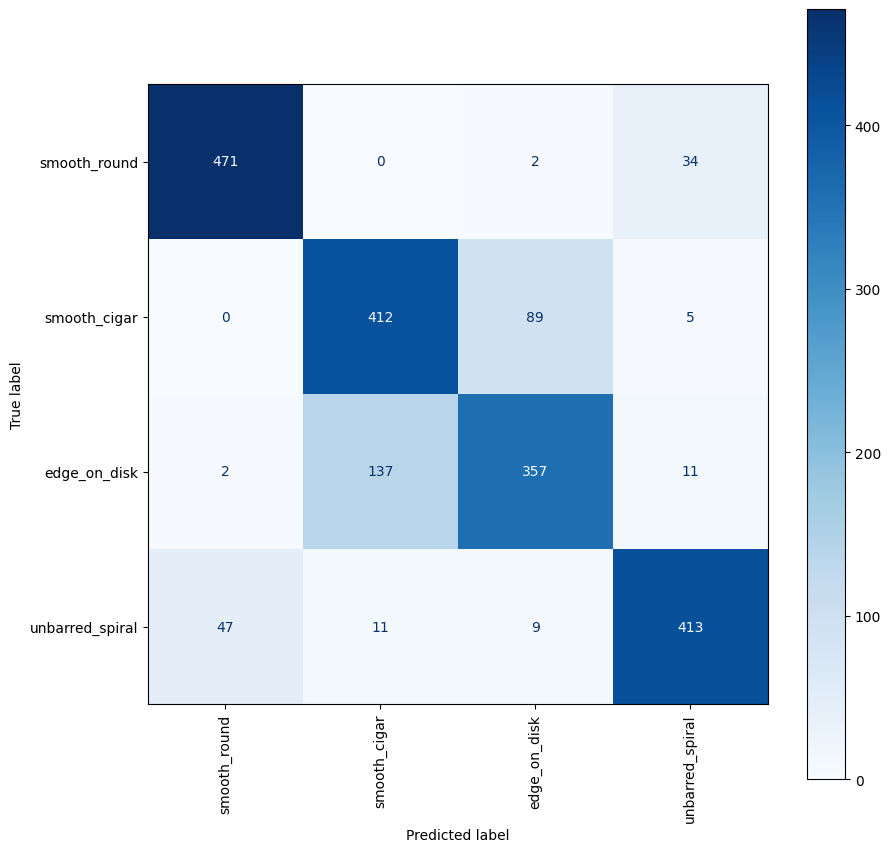

In [14]:
fig = plt.figure(figsize=(10, 10))

ax = plt.subplot(1, 1, 1)

ConfusionMatrixDisplay(cm, display_labels=class_names).plot(cmap='Blues', xticks_rotation='vertical', values_format='d', ax=ax)
plt.show()

In [15]:
print(classification_report(conv_labels, y_hat, target_names=class_names))

                 precision    recall  f1-score   support

   smooth_round       0.91      0.93      0.92       507
   smooth_cigar       0.74      0.81      0.77       506
   edge_on_disk       0.78      0.70      0.74       507
unbarred_spiral       0.89      0.86      0.88       480

       accuracy                           0.83      2000
      macro avg       0.83      0.83      0.83      2000
   weighted avg       0.83      0.83      0.83      2000

